Transformers vs. LSTM for Stock Price Time Series Prediction 
https://medium.com/@mskmay66/transformers-vs-lstm-for-stock-price-time-series-prediction-3a26fcc1a782

Prediction of Stock Price Time Series using Transformers Lorenzo D. Costa1, Alexei M. C. Machado August 2023
https://www.researchgate.net/publication/372947061_Prediction_of_Stock_Price_Time_Series_using_Transformers

Stock Price Forecast: Comparison of LSTM, HMM, and Transformer Qianzhun Wang1(B) and Yingqing Yuan2
https://www.researchgate.net/publication/372632831_Stock_Price_Forecast_Comparison_of_LSTM_HMM_and_Transformer

Test another transformers model

testing againt

In [2]:

import pandas as pd
import numpy as np
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import yfinance as yf
from keras import layers
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import time
from datetime import datetime

In [2]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput1, datainput2, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None) -> None:
        self.datainput1 = datainput1
        self.datainput2 = datainput2
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler

        self.df1 = self.extract_historic_data(datainput1)
        self.df2 = self.extract_historic_data(datainput2)

        self.train1, self.test1 = self.etl(self.df1)
        self.train2, self.test2 = self.etl(self.df2)

        self.X_train1, self.y_train1 = self.to_supervised(self.train1)
        self.X_train2, _ = self.to_supervised(self.train2)

        self.X_test1, self.y_test1 = self.to_supervised(self.test1)
        self.X_test2, _ = self.to_supervised(self.test2)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self, datainput) -> pd.Series:
        """
        Extracts historic data and optionally normalizes it.
        """
        # data = self.datainput
        if self.normalize_bool:
            data = self.scaler.fit_transform(
                datainput.values.reshape(-1, 1))
        else:
            data = datainput
        return data

    def split_data(self, data) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        # data = self.df
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        output = result.reshape((samples, self.timestep, NUM_FEATURES))
        print(output.shape)
        return output

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        # print("train:", train, "test:", test)
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self, data) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data(data)
        return self.transform(train, test)

    def to_supervised(self, data, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        # data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        print(np.array(X), np.array(y))
        return np.array(X), np.array(y)

# *******************************
# Implementing a Transformer


class TransformerEncoderLayer(nn.Module):
    def __init__(self, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
        super(TransformerEncoderLayer, self).__init__()
        self.layer_norm1 = nn.LayerNorm(head_size, eps=epsilon)
        self.multi_head_attention = nn.MultiheadAttention(
            embed_dim=head_size, num_heads=num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(head_size, eps=epsilon)
        self.conv1 = nn.Conv1d(head_size, ff_dim, kernel_size)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(ff_dim, head_size, kernel_size)

    def forward(self, x):
        x_norm = self.layer_norm1(x)
        attn_output, _ = self.multi_head_attention(x_norm, x_norm, x_norm)
        x = self.dropout1(attn_output) + x

        x_norm = self.layer_norm2(x)
        x_norm = x_norm.permute(0, 2, 1)
        x_ff = self.conv1(x_norm)
        x_ff = self.relu(x_ff)
        x_ff = self.dropout2(x_ff)
        x_ff = self.conv2(x_ff)
        x_ff = x_ff.permute(0, 2, 1)

        return x_ff + x


class TransformerModel(nn.Module):
    def __init__(self, head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
        super(TransformerModel, self).__init__()
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(
                head_size, num_heads, ff_dim, dropout, epsilon, attention_axes, kernel_size)
            for _ in range(num_trans_blocks)
        ])
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        mlp_layers = []
        for dim in mlp_units:
            mlp_layers.append(nn.Linear(head_size, dim))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(mlp_dropout))
        self.mlp = nn.Sequential(*mlp_layers)
        self.output_layer = nn.Linear(mlp_units[-1], 1)

    def forward(self, x1, x2):
        for encoder in self.encoder_layers:
            x1 = encoder(x1)
            x2 = encoder(x2)

        x1 = self.global_avg_pool(x1.permute(0, 2, 1)).squeeze(-1)
        x2 = self.global_avg_pool(x2.permute(0, 2, 1)).squeeze(-1)
        combined = torch.cat((x1, x2), dim=-1)
        combined = self.mlp(combined)
        return self.output_layer(combined)


# Fit transformer function
def fit_transformer(model, X_train1, X_train2, y_train, X_val1, X_val2, y_val, display_loss=False, epochs=25, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    history = {'loss': [], 'val_loss': []}

    train_data = TensorDataset(torch.tensor(X_train1, dtype=torch.float32), torch.tensor(
        X_train2, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_data = TensorDataset(torch.tensor(X_val1, dtype=torch.float32), torch.tensor(
        X_val2, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs1, inputs2, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs1, inputs2, labels in val_loader:
                outputs = model(inputs1, inputs2)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        history['loss'].append(running_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))

        if display_loss:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss /
                  len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')

    if display_loss:
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return history
# **********************


class PredictAndForecast:
    def __init__(self, model, train1, train2, test1, test2, n_input=5, scaler=None, normalize_bool=False) -> None:
        self.model = model
        self.train1 = train1
        self.train2 = train2
        self.test1 = test1
        self.test2 = test2
        self.n_input = n_input
        self.scaler = scaler
        self.normalize_bool = normalize_bool
        self.predictions = self.get_predictions()

    def forecast(self, history1, history2) -> np.array:
        data1 = np.array(history1)
        data1 = data1.reshape(
            (data1.shape[0] * data1.shape[1], data1.shape[2]))
        data2 = np.array(history2)
        data2 = data2.reshape(
            (data2.shape[0] * data2.shape[1], data2.shape[2]))

        input_x1 = data1[-self.n_input:, :]
        input_x2 = data2[-self.n_input:, :]

        input_x1 = input_x1.reshape((1, len(input_x1), input_x1.shape[1]))
        input_x2 = input_x2.reshape((1, len(input_x2), input_x2.shape[1]))

        input_x1 = torch.tensor(input_x1, dtype=torch.float32)
        input_x2 = torch.tensor(input_x2, dtype=torch.float32)

        self.model.eval()
        with torch.no_grad():
            yhat = self.model(input_x1, input_x2).numpy()

        return yhat[0]

    def get_predictions(self) -> np.array:
        history1 = [x for x in self.train1]
        history2 = [x for x in self.train2]

        predictions = []
        for i in range(len(self.test1)):
            yhat_sequence = self.forecast(history1, history2)
            predictions.append(yhat_sequence)
            history1.append(self.test1[i, :])
            history2.append(self.test2[i, :])

        predictions = np.array(predictions)
        return predictions


class Evaluate:

    def __init__(self, actual, predictions, normalize_bool=False, scaler=None) -> None:

        min_len = min(len(actual), len(predictions))
        self.actual = actual[:min_len]
        self.predictions = predictions[:min_len]

        print(
            f"Initial lengths - actual: {len(actual)}, predictions: {len(predictions)}")
        if normalize_bool:
            actual = scaler.inverse_transform(
                actual.reshape(-1, 1)).reshape(actual.shape)
            predictions = scaler.inverse_transform(
                predictions.reshape(-1, 1)).reshape(predictions.shape)
        # Print first 5 values for brevity
        print(f"Transformed actual: {self.actual[:5]}")
        print(f"Transformed predictions: {self.predictions[:5]}")
        self.var_ratio = self.compare_var()
        self.mape = self.evaluate_model_with_mape()
        self.rmse = self.evaluate_model_with_rmse()
        self.mae = self.evaluate_model_with_mae()
        self.r2 = self.evaluate_model_with_r2()

    def compare_var(self):
        return abs(1 - (np.var(self.predictions.flatten()) / np.var(self.actual.flatten())))

    def evaluate_model_with_mape(self):
        mape = mean_absolute_percentage_error(
            self.actual.flatten(), self.predictions.flatten())
        print(f"MAPE: {mape}")
        return mape

    def evaluate_model_with_rmse(self):
        rmse = root_mean_squared_error(
            self.actual.flatten(), self.predictions.flatten())
        print(f"RMSE: {rmse}")
        return rmse

    def evaluate_model_with_mae(self):
        mae = mean_absolute_error(
            self.actual.flatten(), self.predictions.flatten())
        print(f"MAE: {mae}")
        return mae

    def evaluate_model_with_r2(self):
        r2 = r2_score(self.actual.flatten(), self.predictions.flatten())
        print(f"R-squared: {r2}")
        return r2


def plot_results(train, test, preds, df, normalize_bool=False, scaler=None, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """

    fig, ax = plt.subplots(figsize=(20, 6))
    # x = df.Close[-498:].index
    print(f'train shape: {train.shape}')
    print(f'test shape: {test.shape}')
    print(f'preds shape: {preds.shape}')
    plot_train = train.squeeze(axis=-1).flatten()
    plot_test = test.squeeze(axis=-1).flatten()
    plot_preds = preds.flatten()
    # .flatten()
    if normalize_bool:
        # Inverse transform to get back to original scale
        plot_test = scaler.inverse_transform(
            plot_test.reshape(-1, 1)).reshape(plot_test.shape)
        train = scaler.inverse_transform(
            train.reshape(-1, 1)).reshape(train.shape)
        plot_preds = scaler.inverse_transform(
            plot_preds.reshape(-1, 1)).reshape(plot_preds.shape)
        print("normalization convert active")
    print(f'plot_train shape: {plot_train.shape}')
    print(f'plot_test shape: {plot_test.shape}')
    print(f'plot_preds shape: {plot_preds.shape}')

    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    x_train = df[:len(plot_train)].index
    x_test = df[len(plot_train):len(plot_train) + len(plot_test)].index

    if len(plot_preds) > len(x_test):
        plot_preds = plot_preds[:len(x_test)]
    elif len(plot_preds) < len(x_test):
        plot_preds = np.pad(plot_preds, (0, len(
            x_test) - len(plot_preds)), 'constant', constant_values=np.nan)

    ax.plot(x_train, plot_train, label='Train', color='blue')
    ax.plot(x_test, plot_test, label='actual', color='red')
    ax.plot(x_test, plot_preds, label='preds', color='green')
    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

In [5]:
ticker = 'aapl'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset['Close'] = dataset['Close']


def kama_indicator(price, period=10, period_fast=2, period_slow=30):
    price = pd.Series(price)
    if len(price) < period:
        raise ValueError(
            "Price series length is less than the period specified.")
    # Efficiency Ratio
    change = abs(price-price.shift(period))
    volatility = (abs(price-price.shift())).rolling(period).sum()
    er = change/volatility

    # Smoothing Constant
    sc_fatest = 2/(period_fast + 1)
    sc_slowest = 2/(period_slow + 1)
    sc = (er * (sc_fatest - sc_slowest) + sc_slowest)**2

    # KAMA
    kama = np.zeros_like(price)
    kama[period-1] = price[period-1]

    for i in range(period, len(price)):
        kama[i] = kama[i-1] + sc[i] * (price[i] - kama[i-1])

    kama[:period] = np.nan

    return pd.Series(kama, index=price.index)


def calculate_TEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    tema = (3 * ema1) - (3 * ema2) + ema3
    return tema.dropna()


def calculate_DEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    dema = 2 * ema1 - ema2
    return dema


def calculate_ZLEMA(prices, period):
    prices = pd.Series(prices)  # Ensure prices is a pandas Series
    lag = period // 2
    adjusted_prices = [
        2 * prices[i] - (prices[i - lag] if i >= lag else prices[0]) for i in range(len(prices))
    ]
    adjusted_prices = pd.Series(adjusted_prices)
    zlema = adjusted_prices.ewm(span=period, adjust=False).mean()
    return pd.Series(zlema)


def adaptive_period_moving_average(prices, min_period=5, max_period=30):
    atr = np.zeros_like(prices)
    adjusted_periods = np.zeros_like(prices)
    moving_averages = np.full_like(prices, np.nan)

    for i in range(1, len(prices)):
        atr[i] = atr[i-1] + (abs(prices[i] - prices[i-1]) - atr[i-1]) / 14

        min_volatility = atr[1:i+1].min()
        max_volatility = atr[1:i+1].max()

        if max_volatility == min_volatility:
            adjusted_period = min_period
        else:
            adjusted_period = int(((max_period - min_period) / (
                max_volatility - min_volatility)) * (atr[i] - min_volatility) + min_period)

        adjusted_periods[i] = adjusted_period

        if i >= adjusted_period:
            moving_averages[i] = np.mean(prices[i-adjusted_period+1:i+1])

    return pd.Series(moving_averages)


def weighted_moving_average(data, periods):
    weights = np.arange(1, periods + 1)
    wma = data.rolling(periods).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return wma

[*********************100%%**********************]  1 of 1 completed


In [4]:
# ticker = 'NDX'
ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

data1 = calculate_DEMA(dataset['Close'], 10)
data2 = calculate_TEMA(dataset['Close'], 10)

df = pd.DataFrame(
    {'price close': dataset['Close'], 'DEMA': data1, 'TEMA': data2})

# print(df)

print(df)

[*********************100%%**********************]  1 of 1 completed

            price close        DEMA        TEMA
Date                                           
1990-01-02     0.332589    0.332589    0.332589
1990-01-03     0.334821    0.333327    0.333599
1990-01-04     0.335938    0.334239    0.334771
1990-01-05     0.337054    0.335275    0.336033
1990-01-08     0.339286    0.336766    0.337844
...                 ...         ...         ...
2024-07-23   225.009995  227.442308  224.754788
2024-07-24   218.539993  224.693221  221.375573
2024-07-25   217.490005  222.302408  218.712986
2024-07-26   217.960007  220.698230  217.263572
2024-07-29   218.240005  219.626401  216.564154

[8709 rows x 3 columns]


In [5]:

normaliza_bool_update = False
type_normalisation_update = None

etl = ETL(datainput1=dataset, datainput2=data1,
          test_size=0.2, n_input=5, timestep=5,
          normalize_bool=normaliza_bool_update,
          scaler=type_normalisation_update)

X_train1, y_train1 = etl.X_train1, etl.y_train1
X_train2, _ = etl.X_train2, None
X_test1, y_test1 = etl.X_test1, etl.y_test1
X_test2, _ = etl.X_test2, None

model = TransformerModel(head_size=128, num_heads=4, ff_dim=2,
                         num_trans_blocks=4, mlp_units=[256], dropout=0.10, mlp_dropout=0.10)
# Train the model
history = fit_transformer(model, X_train1, X_train2, y_train1, X_test1,
                          X_test2, y_test1, display_loss=True, epochs=25, learning_rate=1e-3)

# Make predictions
transformer_preds = PredictAndForecast(model, train1=X_train1, train2=X_train2, test1=X_test1,
                                       test2=X_test2, n_input=5, scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)
print("Predictions shape:", transformer_preds.predictions.shape)
# Train the model
# history = fit_transformer(model, train_loader, val_loader,
#                           display_loss=True, epochs=25, learning_rate=1e-3)
# transformer = build_transfromer(head_size=128, num_heads=4,
#                                 ff_dim=2, num_trans_blocks=4,
#                                 mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

# hist = fit_transformer(transformer,
#                        X_train1, X_train2, y_train1, X_test1, X_test2, y_test1,
#                        display_loss=True)

# transformer_preds = PredictAndForecast(transformer, train1=X_train1, train2=X_train2, test1=X_test1, test2=X_test2, n_input=5,
#                                        scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)
# print("Predictions shape:", transformer_preds.predictions.shape)

(1393, 5, 1)
(348, 5, 1)
(1393, 5, 1)
(348, 5, 1)
[[[ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]
  [ 0.32142901]]

 [[ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]
  [ 0.32142901]
  [ 0.308036  ]]

 [[ 0.339286  ]
  [ 0.33593801]
  [ 0.32142901]
  [ 0.308036  ]
  [ 0.308036  ]]

 ...

 [[40.02000046]
  [40.26499939]
  [38.83000183]
  [39.36999893]
  [39.96250153]]

 [[40.26499939]
  [38.83000183]
  [39.36999893]
  [39.96250153]
  [40.40000153]]

 [[38.83000183]
  [39.36999893]
  [39.96250153]
  [40.40000153]
  [40.23749924]]] [[ 0.308036    0.308036    0.30580401  0.31138399  0.296875  ]
 [ 0.308036    0.30580401  0.31138399  0.296875    0.28906301]
 [ 0.30580401  0.31138399  0.296875    0.28906301  0.30580401]
 ...
 [40.40000153 40.23749924 39.46500015 39.375      39.30250168]
 [40.23749924 39.46500015 39.375      39.30250168 39.94499969]
 [39.46500015 39.375      39.30250168 39.94499969 39.99499893]]
[[[ 0.33423943]
  [ 0.33527542]
  [ 0.33676557]
  [ 0.33673966]
  [ 

RuntimeError: Given normalized_shape=[128], expected input with shape [*, 128], but got input of size[32, 5, 1]

##########################

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import numpy as np


class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput1, datainput2, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None) -> None:
        self.datainput1 = datainput1
        self.datainput2 = datainput2
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler

        self.df1 = self.extract_historic_data(datainput1)
        self.df2 = self.extract_historic_data(datainput2)

        self.train1, self.test1 = self.etl(self.df1)
        self.train2, self.test2 = self.etl(self.df2)

        self.X_train1, self.y_train1 = self.to_supervised(self.train1)
        self.X_train2, _ = self.to_supervised(self.train2)

        self.X_test1, self.y_test1 = self.to_supervised(self.test1)
        self.X_test2, _ = self.to_supervised(self.test2)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self, datainput) -> pd.Series:
        """
        Extracts historic data and optionally normalizes it.
        """
        # data = self.datainput
        if self.normalize_bool:
            data = self.scaler.fit_transform(
                datainput.values.reshape(-1, 1))
        else:
            data = datainput
        return data

    def split_data(self, data) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        # data = self.df
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        output = result.reshape((samples, self.timestep, NUM_FEATURES))
        print(output.shape)
        return output

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        # print("train:", train, "test:", test)
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self, data) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data(data)
        return self.transform(train, test)

    def to_supervised(self, data, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        # data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        print(np.array(X), np.array(y))
        return np.array(X), np.array(y)

# *******************************
# Implementing a Transformer


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size,
                      activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = 5, 1, 1  # 5 1 5
    inputs1 = tf.keras.Input(shape=(n_timesteps, n_features))
    inputs2 = tf.keras.Input(shape=(n_timesteps, n_features))
    x1 = layers.Masking()(inputs1)  # Masking layer
    x2 = layers.Masking()(inputs2)
    for _ in range(num_trans_blocks):
        x1 = transformer_encoder(x1, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                 dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)
        x2 = transformer_encoder(x2, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                 dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

    x1 = layers.GlobalAveragePooling1D(data_format="channels_first")(x1)
    x2 = layers.GlobalAveragePooling1D(data_format="channels_first")(x2)
    combined = layers.Concatenate()([x1, x2])
    for dim in mlp_units:
        combined = layers.Dense(dim, activation="relu")(combined)
        combined = layers.Dropout(mlp_dropout)(combined)

    outputs = layers.Dense(n_outputs)(combined)
    return tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)


def fit_transformer(transformer: tf.keras.Model, x_train1, x_train2, y_train, x_val1, x_val2, y_val, display_loss=False):
    """
    Compiles and fits our transformer.
    """
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape'])

    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=10, restore_best_weights=True)]
    start = time.time()
    # hist = transformer.fit(data.X_train, data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    hist = transformer.fit([x_train1, x_train2], y_train, validation_data=(
        [x_val1, x_val2], y_val), batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    print("time used", time.time() - start)

    history_df = pd.DataFrame(hist.history)

    if display_loss:
        history_df['loss'].plot()
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show()
        history_df['val_loss'].plot()
        plt.title('Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper right')
        plt.show()

        # Display minimum validation loss
        min_val_loss = history_df['val_loss'].min()
        print("Minimum validation loss: {:.4f}".format(min_val_loss))
        # Plot mae
        history_df.loc[:, ['mae', 'val_mae']].plot()
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
        # Display minimum validation mae and mape
        min_val_mae = history_df['val_mae'].min()
        min_val_mape = history_df['val_mape'].min()
        print("Minimum validation MAE: {:.4f}".format(min_val_mae))
        print("Minimum validation MAPE: {:.4f}".format(min_val_mape))

    return hist

# **********************


class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """

    def __init__(self, model, train1, train2, test1, test2, n_input=5, scaler=None, normalize_bool=False) -> None:
        self.model = model
        self.train1 = train1
        self.train2 = train2
        self.test1 = test1
        self.test2 = test2
        self.n_input = n_input
        self.scaler = scaler
        self.normalize_bool = normalize_bool
        self.predictions = self.get_predictions()

    def forecast(self, history1, history2) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data1 = np.array(history1)
        data1 = data1.reshape((data1.shape[0]*data1.shape[1], data1.shape[2]))
        data2 = np.array(history2)
        data2 = data2.reshape((data2.shape[0]*data2.shape[1], data2.shape[2]))
        # retrieve last observations for input data
        input_x1 = data1[-self.n_input:, :]
        input_x2 = data2[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x1 = input_x1.reshape((1, len(input_x1), input_x1.shape[1]))
        input_x2 = input_x2.reshape((1, len(input_x2), input_x2.shape[1]))
        # forecast the next week
        yhat = self.model.predict([input_x1, input_x2], verbose=0)
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history1 = [x for x in self.train1]
        history2 = [x for x in self.train2]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test1)):
            yhat_sequence = self.forecast(history1, history2)
            predictions.append(yhat_sequence)
            # Get real observation and add to history for predicting the next week
            history1.append(self.test1[i, :])
            history2.append(self.test2[i, :])
        predictions = np.array(predictions)
        # if self.normalize_bool:
        # Inverse transform to get back to original scale
        #    predictions = self.scaler.inverse_transform(
        #        predictions.reshape(-1, 1)).reshape(predictions.shape)
        return predictions


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


class Evaluate:
    def __init__(self, actual, predictions, normalize_bool=False, scaler=None) -> None:
        # Ensure both actual and predictions are numpy arrays
        actual = np.array(actual)
        predictions = np.array(predictions)

        # Check dimensions and reshape if necessary
        if actual.ndim > 2:
            actual = actual.reshape(actual.shape[0], -1)
        if predictions.ndim > 2:
            predictions = predictions.reshape(predictions.shape[0], -1)

        # Flatten the arrays to 1D
        actual = actual.flatten()
        predictions = predictions.flatten()

        # Initial lengths for debugging
        print(
            f"Initial lengths - actual: {len(actual)}, predictions: {len(predictions)}")

        # Trim sequences to the minimum length
        min_len = min(len(actual), len(predictions))
        self.actual = actual[:min_len]
        self.predictions = predictions[:min_len]

        # Debugging trimmed lengths
        print(f"Trimmed lengths - actual: {len(self.actual)
                                           }, predictions: {len(self.predictions)}")

        if normalize_bool and scaler is not None:
            self.actual = scaler.inverse_transform(
                self.actual.reshape(-1, 1)).flatten()
            self.predictions = scaler.inverse_transform(
                self.predictions.reshape(-1, 1)).flatten()

        # Debugging transformed data
        print(f"Transformed actual: {self.actual[:5]}")
        print(f"Transformed predictions: {self.predictions[:5]}")

        # Ensure lengths after transformation
        min_len_after_transform = min(len(self.actual), len(self.predictions))
        self.actual = self.actual[:min_len_after_transform]
        self.predictions = self.predictions[:min_len_after_transform]

        # Debugging lengths after transformation
        print(f"Final lengths - actual: {len(self.actual)
                                         }, predictions: {len(self.predictions)}")

        self.var_ratio = self.compare_var()
        self.mape = self.evaluate_model_with_mape()
        self.rmse = self.evaluate_model_with_rmse()
        self.mae = self.evaluate_model_with_mae()
        self.r2 = self.evaluate_model_with_r2()

    def compare_var(self):
        return abs(1 - (np.var(self.predictions) / np.var(self.actual)))

    def evaluate_model_with_mape(self):
        mape = mean_absolute_percentage_error(self.actual, self.predictions)
        return mape

    def evaluate_model_with_rmse(self):
        rmse = root_mean_squared_error(self.actual, self.predictions)
        return rmse

    def evaluate_model_with_mae(self):
        mae = mean_absolute_error(self.actual, self.predictions)
        return mae

    def evaluate_model_with_r2(self):
        r2 = r2_score(self.actual, self.predictions)
        return r2


def plot_results(train, test, preds, df, normalize_bool=False, scaler=None, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """

    fig, ax = plt.subplots(figsize=(20, 6))
    # x = df.Close[-498:].index
    print(f'train shape: {train.shape}')
    print(f'test shape: {test.shape}')
    print(f'preds shape: {preds.shape}')
    plot_train = train.squeeze(axis=-1).flatten()
    plot_test = test.squeeze(axis=-1).flatten()
    plot_preds = preds.flatten()
    # .flatten()
    if normalize_bool:
        # Inverse transform to get back to original scale
        plot_test = scaler.inverse_transform(
            plot_test.reshape(-1, 1)).reshape(plot_test.shape)
        train = scaler.inverse_transform(
            train.reshape(-1, 1)).reshape(train.shape)
        plot_preds = scaler.inverse_transform(
            plot_preds.reshape(-1, 1)).reshape(plot_preds.shape)
        print("normalization convert active")
    print(f'plot_train shape: {plot_train.shape}')
    print(f'plot_test shape: {plot_test.shape}')
    print(f'plot_preds shape: {plot_preds.shape}')

    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    x_train = df[:len(plot_train)].index
    x_test = df[len(plot_train):len(plot_train) + len(plot_test)].index

    if len(plot_preds) > len(x_test):
        plot_preds = plot_preds[:len(x_test)]
    elif len(plot_preds) < len(x_test):
        plot_preds = np.pad(plot_preds, (0, len(
            x_test) - len(plot_preds)), 'constant', constant_values=np.nan)

    ax.plot(x_train, plot_train, label='Train', color='blue')
    ax.plot(x_test, plot_test, label='actual', color='red')
    ax.plot(x_test, plot_preds, label='preds', color='green')
    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

In [6]:
ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

data1 = calculate_DEMA(dataset['Close'], 10)
data2 = calculate_TEMA(dataset['Close'], 10)

[*********************100%%**********************]  1 of 1 completed


(1393, 5, 1)
(348, 5, 1)
(1393, 5, 1)
(348, 5, 1)
[[[ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]
  [ 0.32142901]
  [ 0.308036  ]]

 [[ 0.339286  ]
  [ 0.33593801]
  [ 0.32142901]
  [ 0.308036  ]
  [ 0.308036  ]]

 [[ 0.33593801]
  [ 0.32142901]
  [ 0.308036  ]
  [ 0.308036  ]
  [ 0.30580401]]

 ...

 [[40.26499939]
  [38.83000183]
  [39.36999893]
  [39.96250153]
  [40.40000153]]

 [[38.83000183]
  [39.36999893]
  [39.96250153]
  [40.40000153]
  [40.23749924]]

 [[39.36999893]
  [39.96250153]
  [40.40000153]
  [40.23749924]
  [39.46500015]]] [[ 0.308036    0.30580401  0.31138399  0.296875    0.28906301]
 [ 0.30580401  0.31138399  0.296875    0.28906301  0.30580401]
 [ 0.31138399  0.296875    0.28906301  0.30580401  0.296875  ]
 ...
 [40.23749924 39.46500015 39.375      39.30250168 39.94499969]
 [39.46500015 39.375      39.30250168 39.94499969 39.99499893]
 [39.375      39.30250168 39.94499969 39.99499893 39.81750107]]
[[[ 0.33527542]
  [ 0.33676557]
  [ 0.33673966]
  [ 0.33189945]
  [ 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy th

218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 12.9092 - mae: 1.3748 - mape: 50.6591 - val_loss: 20.6471 - val_mae: 3.2410 - val_mape: 2.8791
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.1561 - mae: 0.5192 - mape: 20.5253 - val_loss: 25.9339 - val_mae: 3.7292 - val_mape: 3.3012
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.7685 - mae: 0.4293 - mape: 20.2077 - val_loss: 20.4797 - val_mae: 3.1895 - val_mape: 2.8169
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5417 - mae: 0.3765 - mape: 16.9132 - val_loss: 19.4334 - val_mae: 3.0894 - val_mape: 2.7266
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.4463 - mae: 0.3391 - mape: 13.8782 - val_loss: 20.0799 - val_mae: 3.1879 - val_mape: 2.8186
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.4329 - mae: 0.3245 - mape: 11.4699 - val_loss: 25.1806 - val_mae: 3.6878 - val_mape: 3.2729
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3551 - mae: 0.29

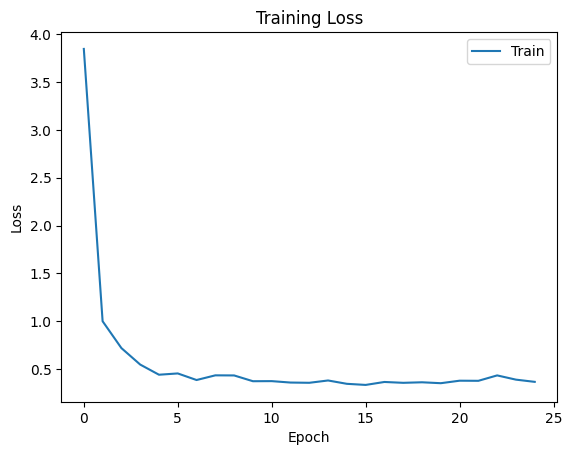

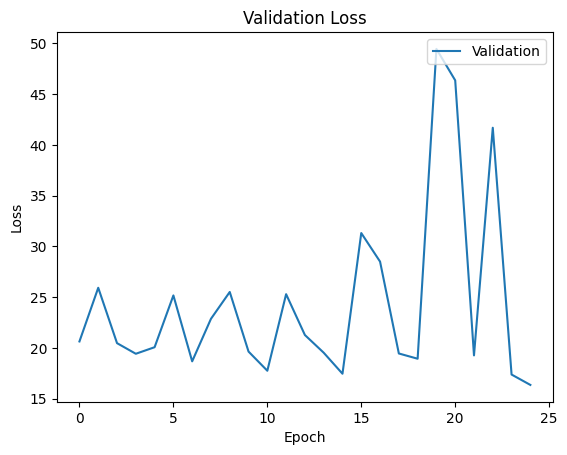

Minimum validation loss: 16.3653


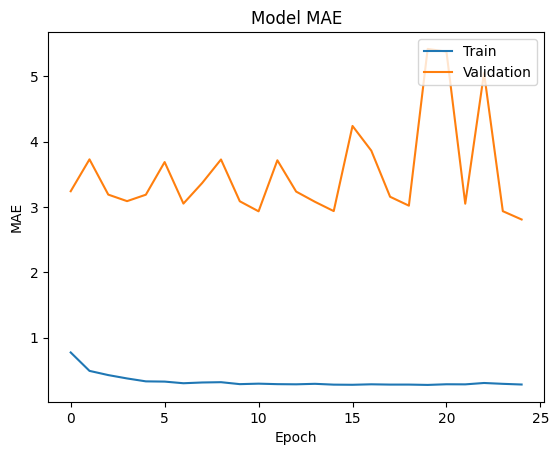

Minimum validation MAE: 2.8085
Minimum validation MAPE: 2.4868


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy th

Predictions shape: (1731, 1)


In [7]:
normaliza_bool_update = False
type_normalisation_update = None

etl = ETL(datainput1=dataset, datainput2=data1,
          test_size=0.2, n_input=5, timestep=5,
          normalize_bool=normaliza_bool_update,
          scaler=type_normalisation_update)

X_train1, y_train1 = etl.X_train1, etl.y_train1
X_train2, _ = etl.X_train2, None
X_test1, y_test1 = etl.X_test1, etl.y_test1
X_test2, _ = etl.X_test2, None
transformer = build_transfromer(head_size=128, num_heads=4,
                                ff_dim=2, num_trans_blocks=4,
                                mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

hist = fit_transformer(transformer,
                       X_train1, X_train2, y_train1, X_test1, X_test2, y_test1,
                       display_loss=True)

transformer_preds = PredictAndForecast(transformer, train1=X_train1, train2=X_train2, test1=X_test1, test2=X_test2, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)
print("Predictions shape:", transformer_preds.predictions.shape)

In [29]:
transformer.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 5, 1)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 5, 1)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 5, 1)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 5, 1)      │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 1)      │          2 │ masking[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 5)         │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ masking_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 5)         │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 1)      │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ any[0][0],        │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 1)      │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ any_1[0][0],      │
│                     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 1)      │          0 │ dropout_1[0][0],  │
│                     │                   │            │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 5, 1)      │          0 │ dropout_4[0][0],  │
│                     │                   │            │ masking_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 95,525 (373.15 KB)

 Trainable params: 31,841 (124.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,684 (248.77 KB)

train shape: (1393, 5, 1)
test shape: (348, 5, 1)
preds shape: (1731, 1)
plot_train shape: (6965,)
plot_test shape: (1740,)
plot_preds shape: (1731,)


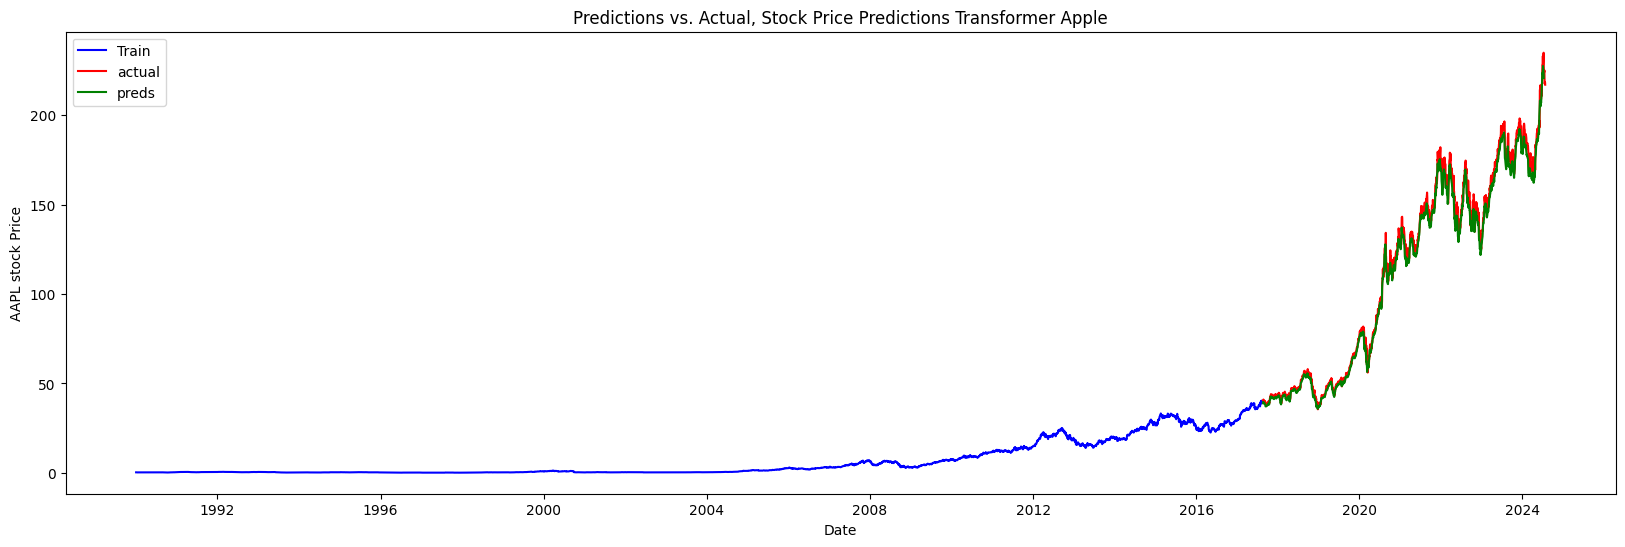

Initial lengths - actual: 1740, predictions: 1731
Trimmed lengths - actual: 1731, predictions: 1731
Transformed actual: [40.72750092 40.83750153 41.         41.01250076 40.52000046]
Transformed predictions: [38.91362  39.684914 39.628445 39.49349  39.172607]
Final lengths - actual: 1731, predictions: 1731
MAPE: 0.026819188659428898
RMSE: 3.9977318595545763
MAE: 3.0627521248238407
R-squared: 0.9946684821794468


In [26]:
# Use the plot_results function to visualize the results
plot_results(train=etl.train1, test=etl.test1, preds=transformer_preds.predictions, df=dataset,
             normalize_bool=normaliza_bool_update, scaler=type_normalisation_update, title_suffix='Stock Price Predictions Transformer Apple')
train_evaluation = Evaluate(etl.test1, transformer_preds.predictions,
                            normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

###########################

In [ ]:
ticker = 'NDX'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.05, dropout=0.05, attention_axes=1)
# transformer.summary()
# train the model
# hist = fit_transformer(transformer)
hist = fit_transformer(transformer, data.X_train,
                       data.y_train, data.X_test, data.y_test, display_loss=True)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer NDX')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

Move average data

In [ ]:

period = 20  # 20 days moving average

ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]
dataset['SMA'] = dataset.rolling(window=period).mean()

normaliza_bool_update = False
type_normalisation_update = None

data_norm = ETL(datainput=dataset['SMA'].dropna(), test_size=0.2, n_input=5, timestep=5,
                normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer_norm = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4,
                                     mlp_units=[256],
                                     mlp_dropout=0.1, dropout=0.1, attention_axes=1)

# train the model
hist = fit_transformer(transformer_norm, data_norm.X_train,
                       data_norm.y_train, data_norm.X_test, data_norm.y_test, display_loss=False)
# time used
transformer_preds_norm = PredictAndForecast(transformer, data_norm.train, data_norm.test, n_input=5,
                                            scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data_norm.train, data_norm.test, transformer_preds_norm.predictions,
             data_norm.df, normaliza_bool_update, type_normalisation_update, title_suffix='SMA Transformer')

train_evaluation = Evaluate(data_norm.test, transformer_preds_norm.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

including Normalization Maxmin

In [ ]:
# ticker = 'NDX'
ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

normaliza_bool_update = True
type_normalisation_update = MinMaxScaler()

data1 = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
            normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer1 = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
    256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer1.summary()
# train the model
hist1 = fit_transformer(transformer1, data1.X_train,
                        data1.y_train, data1.X_test, data1.y_test, display_loss=False)

transformer_preds_1 = PredictAndForecast(transformer1, data1.train, data1.test, n_input=5,
                                         scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data1.train, data1.test, transformer_preds_1.predictions,
             data1.df, normaliza_bool_update, type_normalisation_update, title_suffix='Normalization Transformer AAPL')
train_evaluation = Evaluate(data1.test, transformer_preds_1.predictions,
                            normaliza_bool_update, type_normalisation_update)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

In [ ]:
ticker = 'NDX'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

normaliza_bool_update = True
type_normalisation_update = MinMaxScaler()

data2 = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
            normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer2 = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4,
                                 mlp_units=[256], mlp_dropout=0.05, dropout=0.05, attention_axes=1)
# transformer1.summary()
# train the model
hist1 = fit_transformer(transformer2, data2.X_train,
                        data2.y_train, data2.X_test, data2.y_test, display_loss=True)

transformer_preds_2 = PredictAndForecast(transformer2, data2.train, data2.test, n_input=5,
                                         scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data2.train, data2.test, transformer_preds_2.predictions,
             data2.df, normaliza_bool_update, type_normalisation_update, title_suffix='Normalization Transformer NDX')
train_evaluation = Evaluate(data2.test, transformer_preds_2.predictions,
                            normaliza_bool_update, type_normalisation_update)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

In [ ]:
# plot_results(data.test, transformer_preds.predictions, data.df, title_suffix='Transformer')

fig, ax = plt.subplots(figsize=(20, 6))
# x = df.Close[-498:].index
plot_test = data.test[1:]
plot_preds = transformer_preds.predictions[1:]
x = data.df[-(plot_test.shape[0]*plot_test.shape[1]):].index
plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
ax.plot(x, plot_test, label='actual')
ax.plot(x, plot_preds, label='preds with out normalisation')
ax.set_title(f'Predictions vs. Actual')
ax.set_xlabel('Date')
ax.set_ylabel("Stock Price")
ax.legend()
plt.show()